# Helium Hydride (Untapered HeH+) Exemplar
## Step 0: Import various libraries

In [1]:
# Imports for QSCOUT
import jaqalpaq
from jaqalpaq.core import circuitbuilder
from jaqalpaq.core.circuit import normalize_native_gates
from jaqalpaq.run import run_jaqal_circuit
from qscout.v1 import native_gates
from qscout.v1 import noisy

# Imports for basic mathematical functionality
from math import pi
import numpy as np

# Imports for OpenFermion(-PySCF)
import openfermion as of
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf

# Import for VQE optimizer
from scipy import optimize

# Step 1: SCF calculation to assmble the second-quantized Hamiltonian

In [2]:
# Set the basis set, spin, and charge of the H2 molecule
basis = 'sto-3g'
multiplicity = 1
charge = 1 #Charge is 1 for HeH+

# Set calculation parameters
run_scf = 1
run_fci = 1
delete_input = True
delete_output = False

# Generate molecule at some bond length (0.8 Angstroms here)
geometry = [('He', (0., 0., 0.)), ('H', (0., 0., 0.5))]
molecule = MolecularData(geometry, basis, multiplicity, charge, filename='./HeH+_4_sto-3g_single_0.8') #Set file location of data

# Run pyscf to generate new molecular data for sto-3g HeH+
molecule = run_pyscf(molecule, run_scf=run_scf, run_fci=run_fci, verbose=False)

print("Bond Length in Angstroms: {}".format(0.8))
print("FCI (Exact) energy in Hartrees: {}".format(molecule.fci_energy))

Bond Length in Angstroms: 0.8
FCI (Exact) energy in Hartrees: -2.6407145904882614


## Step 2: Convert the fermionic Hamiltonian to a qubit Hamiltonian

In [3]:
# Get the fermionic Hamiltonian for HeH+ and map it using the BK encoding
hamiltonian = molecule.get_molecular_hamiltonian()
hamiltonian_ferm = of.get_fermion_operator(hamiltonian)
hamiltonian_bk = of.bravyi_kitaev(hamiltonian_ferm)
hamiltonian_jw = of.jordan_wigner(hamiltonian_ferm)

terms = []
cs = []
for term in hamiltonian_jw.terms:
    paulis = [None, None, None, None]
    for pauli in term:
        paulis[pauli[0]] = pauli[1]
    terms += [paulis]
    cs += [hamiltonian_jw.terms[term]]

## Step 3: Define UCC Ansatz circuit in JaqalPaq

In [4]:
def ansatz(theta, term):
    builder = circuitbuilder.CircuitBuilder(native_gates=normalize_native_gates(native_gates.NATIVE_GATES))

    # Create a qubit register
    q = builder.register('q', 4)

    # Define a hadamard macro
    hadamard = circuitbuilder.SequentialBlockBuilder()
    hadamard.gate('Sy', 'a')
    hadamard.gate('Px', 'a')
    builder.macro('hadamard', ['a'], hadamard)

    # Define a CNOT macro
    CNOT = circuitbuilder.SequentialBlockBuilder()

    CNOT.gate('Sy', 'control')
    CNOT.gate('MS', 'control', 'target', 0, np.pi/2)
    Sxd_block = CNOT.block(parallel=True)
    Sxd_block.gate('Sxd', 'control')
    Sxd_block.gate('Sxd', 'target')
    CNOT.gate('Syd', 'control')

    builder.macro('CNOT', ['control', 'target'], CNOT)

    # Prepare the Hartree Fock state
    builder.gate('prepare_all')
    builder.gate('Px', q[0])
    builder.gate('Px', q[1])

    # Apply the UCC Ansatz exp[-i*theta(X1 Y0)]
    builder.gate('hadamard', q[0])
    builder.gate('hadamard', q[1])
    builder.gate('hadamard', q[2])
    builder.gate('Sxd', q[3])

    builder.gate('CNOT', q[0], q[1])
    builder.gate('CNOT', q[1], q[2])
    builder.gate('CNOT', q[2], q[3])
    builder.gate('Rz', q[3], theta)
    builder.gate('CNOT', q[2], q[3])
    builder.gate('CNOT', q[1], q[2])
    builder.gate('CNOT', q[0], q[1])

    builder.gate('hadamard', q[0])
    builder.gate('hadamard', q[1])
    builder.gate('hadamard', q[2])
    builder.gate('Sx', q[3])


    # Change basis for measurement depending on term
    for j, qubit in enumerate(term):
        if qubit == 'X':
            builder.gate('hadamard', ('array_item', q, j)),
        if qubit == 'Y':
            builder.gate('Sxd', ('array_item', q, j)),
            
    builder.gate('measure_all')

    circuit = builder.build()

    return circuit

## Step 4: Define functions to calculate energy expectation value of Ansatz state

In [5]:
def ansatz_sampling(theta, sample_noise):
    term_probs = []
    for i in range(len(terms)):
        if sample_noise:
            probs = np.zeros(16)
            circuit = ansatz(theta, terms[i])
            sim_result = run_jaqal_circuit(circuit) #Run circuit on emulator
            sim_probs = sim_result.subcircuits[0].probability_by_int
            sample = np.random.choice(16, size=n_samples, p=sim_probs) #Sample from distribution to get probabilities
            
            for count in sample:
                probs[count] += 1 #Increment state counter
            probs = probs/n_samples #Determine probabilities from sampling
            term_probs += [probs] #Combine lists of probs of each term in Hamiltonian
                
        else: #Exact solution without sampling
            circuit = ansatz(theta, terms[i])
            sim_result = run_jaqal_circuit(circuit) #Run circuit on emulator
            sim_probs = sim_result.subcircuits[0].probability_by_int
            term_probs += [sim_probs]
    
    return term_probs

In [6]:
# Calculate energy of one term of the Hamiltonian for one possible state
def term_energy(term, state, coefficient, prob):
    parity = 1
    for i in range(len(term)):
        #Change parity if state is occupied and is acted on by a pauli operator
        if term[i] != None and state[i] == '1':
            parity = -1*parity
    return coefficient*prob*parity

# Calculate energy of the molecule for a given value of theta
def calculate_energy(theta, sample_noise):
    energy = 0
    probs = ansatz_sampling(theta[0], sample_noise) #Convert tuple (from optimization) to float for circuit
    for i in range(len(terms)): #For each term in the hamiltonian
        for j in range(len(probs[0])): #For each possible state
            term = terms[i]
            state = '{0:04b}'.format(j)[::-1] #convert state to binary (# of qubits)
            coefficient = cs[i].real
            prob = probs[i][j]
            #print(term, state, coefficient, prob)
            energy += term_energy(term, state, coefficient, prob)
    return energy

## Step 5: Minimize the energy expectation value in 𝜃

In [7]:
# Minimize the energy using classical optimization
n_samples = 10000
optimize.minimize(fun=calculate_energy, x0=[0.01], args=(False), method="COBYLA")

     fun: -2.640622945386571
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 22
  status: 1
 success: True
       x: array([0.10824453])

## Step 6: Loop over previous steps to calculate ground state energy at different bond lengths

In [8]:
# Set the basis set, spin, and charge of the HeH+ molecule
basis = 'sto-3g'
multiplicity = 1
charge = 1

# Set calculation parameters
run_scf = 1
run_fci = 1
delete_input = True
delete_output = False

optimized_energies = [[], []]
exact_energies = []

# Loop over bond lengths from 0.5 to 1.5 angstroms
n_samples = 10000 # Sample circuit
n_pts = 11 #Number of points 
bond_lengths = np.linspace(0.5,1.5,n_pts)
for diatomic_bond_length in bond_lengths:
    # Generate molecule at some bond length
    geometry = [('He', (0., 0., 0.)), ('H', (0., 0., diatomic_bond_length))]
    description=str(round(diatomic_bond_length, 2))
    molecule = MolecularData(
        geometry, basis, multiplicity, charge,
        description=description,
        filename='./HeH+_4_sto-3g_single_dissociation')

    # Run pyscf to generate new molecular data for sto-3g HeH+
    molecule = run_pyscf(molecule, run_scf=run_scf, run_fci=run_fci, verbose=False)
    
    # Get the fermionic Hamiltonian for HeH+ and map it using the BK encoding
    hamiltonian = molecule.get_molecular_hamiltonian()
    hamiltonian_ferm = of.get_fermion_operator(hamiltonian)
    hamiltonian_jw = of.jordan_wigner(hamiltonian_ferm)
    hamiltonian_bk = of.bravyi_kitaev(hamiltonian_ferm)

    # Define terms and coefficients of our Hamiltonian
    terms = []
    cs = []
    for term in hamiltonian_jw.terms:
        paulis = [None, None, None, None]
        for pauli in term:
            paulis[pauli[0]] = pauli[1]
        terms += [paulis][::-1]
        cs += [hamiltonian_jw.terms[term]]

    # Minimize the expectation value of the energy using a classical optimizer (SPSA)
    exact_energies.append(molecule.fci_energy)
    print("R={}\t Exact Energy: {}".format(str(round(diatomic_bond_length, 2)), molecule.fci_energy))
    
    for i in range(2):
        result = optimize.minimize(fun=calculate_energy, x0=[0.01], args=(i), method="COBYLA")
        optimized_energies[i].append(result.fun)
        print("R={}\t Optimized Energy: {}\t Sampling Noise: {}".format(str(round(diatomic_bond_length, 2)), result.fun, bool(i)))
    print('\n')

R=0.5	 Exact Energy: -2.6407145904882614
R=0.5	 Optimized Energy: -2.640622945386571	 Sampling Noise: False
R=0.5	 Optimized Energy: -2.6400825684657434	 Sampling Noise: True


R=0.6	 Exact Energy: -2.7700093779351307
R=0.6	 Optimized Energy: -2.769846161344779	 Sampling Noise: False
R=0.6	 Optimized Energy: -2.7669915593005734	 Sampling Noise: True


R=0.7	 Exact Energy: -2.830482959063893
R=0.7	 Optimized Energy: -2.8302229120339533	 Sampling Noise: False
R=0.7	 Optimized Energy: -2.823307738146928	 Sampling Noise: True


R=0.8	 Exact Energy: -2.8557086272280108
R=0.8	 Optimized Energy: -2.8553440209439658	 Sampling Noise: False
R=0.8	 Optimized Energy: -2.852028771834031	 Sampling Noise: True


R=0.9	 Exact Energy: -2.86261757879778
R=0.9	 Optimized Energy: -2.862169904085675	 Sampling Noise: False
R=0.9	 Optimized Energy: -2.8630093638677256	 Sampling Noise: True


R=1.0	 Exact Energy: -2.8602051225798046
R=1.0	 Optimized Energy: -2.8597244890292655	 Sampling Noise: False
R=1.0	 Op

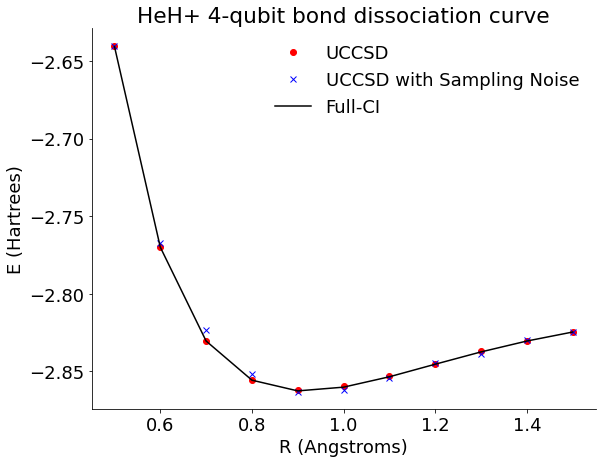

In [9]:
import matplotlib
import matplotlib.pyplot as pyplot

# Plot the various energies for different bond lengths
fig = pyplot.figure(figsize=(10,7))
pyplot.rcParams['font.size']=18
bkcolor = '#ffffff'
ax = fig.add_subplot(1, 1, 1)
pyplot.subplots_adjust(left=.2)
ax.set_xlabel('R (Angstroms)')
ax.set_ylabel(r'E (Hartrees)')
ax.set_title(r'HeH+ 4-qubit bond dissociation curve')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
bond_lengths = [float(x) for x in bond_lengths]
ax.plot(bond_lengths, optimized_energies[0], 'o', label='UCCSD', color='red')
ax.plot(bond_lengths, optimized_energies[1], 'x', label='UCCSD with Sampling Noise', color='blue')
ax.plot(bond_lengths, exact_energies, '-', label='Full-CI', color='black')

ax.legend(frameon=False)
pyplot.show()